<a href="https://colab.research.google.com/github/orionhunts-ai/new_models_datasets/blob/main/poetic_storyteller_fluxOSS_0x0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Markov GPT Storytelling Based on Finely Tuned SLM using PET

In [1]:
%pip install -qqq markovify openai python-dotenv pyarrow textblob wandb

In [4]:
from google.colab import userdata
import wandb
!export WANDB_FLUX=549204b31c8e5a20eed488944e715a7f19cb9a79
!wandb login $WANDB_FLUX
wandb.finish()
wandb.init(project="flux2poetry", job_type="markov_transformer_pre",settings=wandb.Settings(start_method="fork"))


wandb: Currently logged in as: orionhunts (synavatelabs). Use `wandb login --relogin` to force relogin


wandb: Currently logged in as: orionhunts (synavatelabs). Use `wandb login --relogin` to force relogin


In [5]:
import pandas as pd
import markovify
import openai
import os
from dotenv import load_dotenv
from textblob import TextBlob

In [7]:
df_poetry = "/content/drive/MyDrive/repos/datasets/flux_poetry/poetry_orion_processed_0x0.csv"
df_books = "/content/drive/MyDrive/repos/datasets/flux_poetry/goodread_books_orion_processed_0x0.csv"

In [8]:
import wandb

'''

WANDB LOGGING FOR MARKOV CHAIN

'''

def log_markov_chain_analysis(correlation_matrix, generated_text, markov_model, run_name="markov_chain_analysis"):
    wandb.init(project="flux2poetry", name=run_name)

    wandb.log({"correlation_matrix_markov": wandb.Table(dataframe=correlation_matrix)})
    wandb.log({"generated_text_markov": generated_text})

    wandb.config.update({
        "state_size": markov_model.state_size,
        "corpus_size": len(markov_model.chain.model),
    })

    model_artifact = wandb.Artifact("markov_chain_model", type="model")
    model_artifact.add_file("markov_model.pkl")
    wandb.log_artifact(model_artifact)

    wandb.finish()
'''
SEPARATE LOGGING ON WANDB FOR TRANSFORMER MODELS

'''
def log_transformer_analysis(correlation_matrix, generated_text, model_name="gpt2", tokenizer_name="gpt2", run_name="transformer_analysis"):
    wandb.init(project="flux2poetry", name=run_name)

    wandb.log({"correlation_matrix_transformer": wandb.Table(dataframe=correlation_matrix)})
    wandb.log({"generated_text_transformer": generated_text})

    wandb.config.update({
        "model_name": model_name,
        "tokenizer_name": tokenizer_name,
    })

    model_artifact = wandb.Artifact("transformer_model", type="model")
    model_artifact.add_file(f"{model_name}_model.pth")
    wandb.log_artifact(model_artifact)

    wandb.finish()

In [12]:
%pip install uuid
from uuid import uuid4

def wandb_history(run):
  api = wandb.Api()
  # run is specified by <entity>/<project>/<run_id>
  run = api.run(f"orion-agents/flux2poetry/{uuid4()}")

  # save the metrics for the run to a csv file
  metrics_dataframe = run.history()
  return metrics_dataframe.to_csv(f"run_{wandb.run}_metrics.csv")

## Unifying Data

In [13]:
# DF_BOOKS
df_books = pd.read_csv(df_books)
#DF_POETRY
df_poetry = pd.read_csv(df_poetry)

In [14]:
df_books['unified_text'] = df_books['title'] + " " + df_books['description'] + " " + df_books['genres']
df_poetry['unified_text'] = df_poetry['Titles'] + " " + df_poetry['Poem'] + " " + df_poetry['Poet']

# Combine both datasets into one
combined_df = pd.concat([df_books[['unified_text', 'book_text_sentiment']],
                         df_poetry[['unified_text', 'poem_sentiment']]],
                        ignore_index=True)

# Normalize sentiment scores (assuming they are on different scales)
combined_df['normalized_sentiment'] = combined_df[['book_text_sentiment', 'poem_sentiment']].mean(axis=1, skipna=True)

                      book_text_sentiment  poem_sentiment  \
book_text_sentiment                   1.0             NaN   
poem_sentiment                        NaN             1.0   
normalized_sentiment                  1.0             1.0   

                      normalized_sentiment  
book_text_sentiment                    1.0  
poem_sentiment                         1.0  
normalized_sentiment                   1.0  


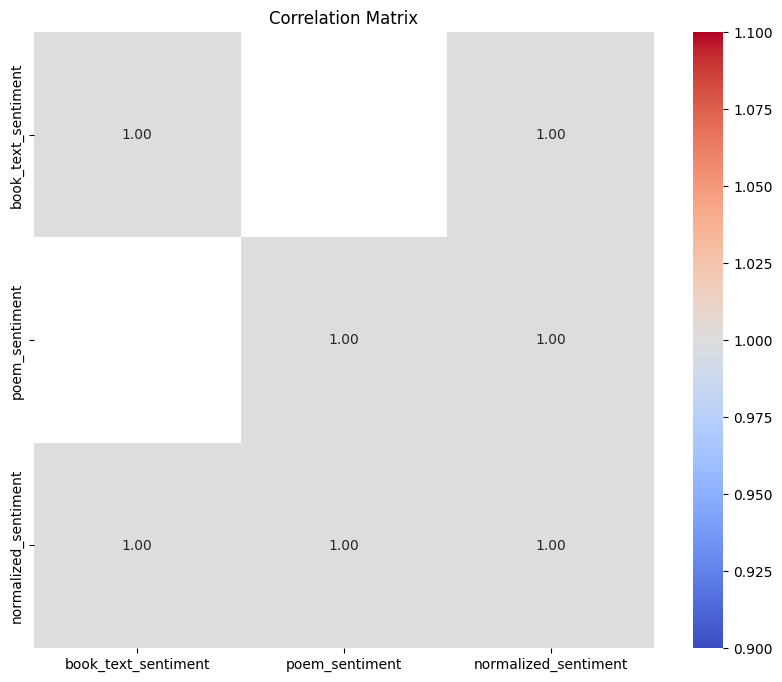

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming combined_df is already defined and includes numerical columns

# Select numerical columns for correlation
numerical_columns = combined_df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numerical_columns.corr()
wandb.log({"correlation_matrix":correlation_matrix})
corr_csv = correlation_matrix.to_csv("/content/drive/MyDrive/repos/datasets/flux_poetry/artifacts/flux_poetry_corr_matrix0x0.csv")
art_corr = wandb.Artifact("correlation_matrix", type="correlation")
art_corr.add_file("/content/drive/MyDrive/repos/datasets/flux_poetry/artifacts/flux_poetry_corr_matrix0x0.csv")
wandb.log_artifact(art_corr)

# Display the correlation matrix
print(correlation_matrix)

# Optionally, visualize the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [21]:
wandb.log({"dataset":combined_df})
combined_df.to_csv("/content/drive/MyDrive/repos/datasets/flux_poetry/artifacts/combined_df.csv")

In [22]:
art_run = wandb.Artifact("combined_df", type="dataset")
art_run.add_file("/content/drive/MyDrive/repos/datasets/flux_poetry/artifacts/combined_df.csv")
wandb.log_artifact(art_run)

<Artifact combined_df>

In [23]:
encoding_markov = combined_df.copy()
encoding_llama3 = combined_df.copy()


# Markov Data Preparation